## Import Dependencies

In [1]:
import os
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

## All countries basic information

In [2]:
!wget https://raw.githubusercontent.com/M-Media-Group/country-json/master/src/countries-master.json

--2021-08-03 23:49:00--  https://raw.githubusercontent.com/M-Media-Group/country-json/master/src/countries-master.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73528 (72K) [text/plain]
Saving to: ‘countries-master.json.2’

countries-master.js 100%[===================>]  71.80K  --.-KB/s    in 0.03s   

2021-08-03 23:49:00 (2.15 MB/s) - ‘countries-master.json.2’ saved [73528/73528]



In [3]:
with open('countries-master.json','r') as f:
    countries_data = json.load(f)

In [4]:
countries_df = pd.DataFrame(countries_data)
print(f'There are {len(countries_df)} entries.')
countries_df.head()

There are 243 entries.


,country,population,sq_km_area,life_expectancy,elevation_in_meters,continent,abbreviation,location,iso,capital_city
0,Afghanistan,35530081,652090.0,45.9,None,Asia,AF,Southern and Central Asia,4,Kabul
1,Albania,2930187,28748.0,71.6,None,Europe,AL,Southern Europe,8,Tirana
2,Algeria,41318142,2381741.0,69.7,800,Africa,DZ,Northern Africa,12,Alger
3,American Samoa,55641,199.0,75.1,None,Oceania,AS,Polynesia,16,Fagatogo
4,Andorra,76965,468.0,83.5,"1,996",Europe,AD,Southern Europe,20,Andorra la Vella


In [5]:
countries_df.to_csv('countries_df.csv')

## Confirmed cases and deaths in each country worldwide (updated hourly)

In [6]:
case_base_url = 'https://covid-api.mmediagroup.fr/v1/cases'
case_data = requests.get(case_base_url).json()
#pprint(case_data)

In [7]:
print(f'There are {len(case_data)} entries.')

There are 196 entries.


## Extract data from API

In [8]:
country = []
confirmed = []
deaths = []

In [9]:
for key,value in case_data.items():
    country.append(key)
    try:
        confirmed.append(value['All']['confirmed'])
    except KeyError:
        confirmed.append(np.nan)
    try:
        deaths.append(value['All']['deaths'])
    except KeyError:
        deaths.append(np.nan)

In [10]:
case_df = pd.DataFrame()
case_df['country'] = country
case_df['confirmed'] = confirmed
case_df['deaths'] = deaths
case_df.head()

,country,confirmed,deaths
0,Afghanistan,148572,6804
1,Albania,133211,2457
2,Algeria,175229,4370
3,Andorra,14766,128
4,Angola,43070,1022


In [11]:
country_case_df = case_df.merge(countries_df,on='country')

In [13]:
print(f'There are {len(country_case_df)} entries.')
country_case_df.head()

There are 180 entries.


,country,confirmed,deaths,population,sq_km_area,life_expectancy,elevation_in_meters,continent,abbreviation,location,iso,capital_city
0,Afghanistan,148572,6804,35530081,652090.0,45.9,None,Asia,AF,Southern and Central Asia,4,Kabul
1,Albania,133211,2457,2930187,28748.0,71.6,None,Europe,AL,Southern Europe,8,Tirana
2,Algeria,175229,4370,41318142,2381741.0,69.7,800,Africa,DZ,Northern Africa,12,Alger
3,Andorra,14766,128,76965,468.0,83.5,"1,996",Europe,AD,Southern Europe,20,Andorra la Vella
4,Angola,43070,1022,29784193,1246700.0,38.3,"1,112",Africa,AO,Central Africa,24,Luanda


In [14]:
country_case_df['population'] = country_case_df['population'].astype(int)
country_case_df['sq_km_area'] = country_case_df['sq_km_area'].astype(float)
country_case_df['life_expectancy'] = country_case_df['life_expectancy'].astype(float)

In [15]:
country_case_df.dtypes

country                 object
confirmed                int64
deaths                   int64
population               int64
sq_km_area             float64
life_expectancy        float64
elevation_in_meters     object
continent               object
abbreviation            object
location                object
iso                     object
capital_city            object
dtype: object

In [16]:
country_case_df['percentage_confirmed_%'] = country_case_df['confirmed']/country_case_df['population'] * 100
country_case_df['percentage_deaths_%'] = country_case_df['deaths']/country_case_df['population'] * 100

In [17]:
country_case_df.head()

,country,confirmed,deaths,population,sq_km_area,life_expectancy,elevation_in_meters,continent,abbreviation,location,iso,capital_city,percentage_confirmed_%,percentage_deaths_%
0,Afghanistan,148572,6804,35530081,652090.0,45.9,None,Asia,AF,Southern and Central Asia,4,Kabul,0.418158,0.019150
1,Albania,133211,2457,2930187,28748.0,71.6,None,Europe,AL,Southern Europe,8,Tirana,4.546160,0.083851
2,Algeria,175229,4370,41318142,2381741.0,69.7,800,Africa,DZ,Northern Africa,12,Alger,0.424097,0.010576
3,Andorra,14766,128,76965,468.0,83.5,"1,996",Europe,AD,Southern Europe,20,Andorra la Vella,19.185344,0.166309
4,Angola,43070,1022,29784193,1246700.0,38.3,"1,112",Africa,AO,Central Africa,24,Luanda,0.144607,0.003431


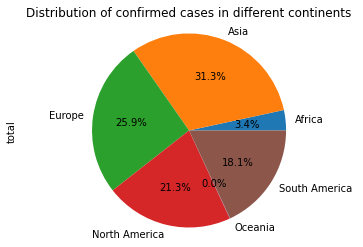

In [18]:
# Generate a pie plot showing the distribution of confirmed cases in different continents
continent_data = country_case_df.groupby('continent').agg(total = ('confirmed','sum'))
continent_data.plot.pie(y='total',autopct = '%1.1f%%',legend=False)
plt.title('Distribution of confirmed cases in different continents')
plt.axis('equal')
plt.show()

In [19]:
country_case_df.to_csv('country_case_df.csv')